In [5]:
!pip install sentencepiece
!git clone https://github.com/google-research/bert

     |████████████████████████████████| 1.0MB 34.4MB/s 
Cloning into 'bert'...
remote: Enumerating objects: 336, done.
remote: Total 336 (delta 0), reused 0 (delta 0), pack-reused 336
Receiving objects: 100% (336/336), 297.11 KiB | 18.57 MiB/s, done.
Resolving deltas: 100% (183/183), done.


In [6]:
import os
import sys
import json
import tensorflow as tf

from glob import glob
from google.colab import auth, drive
from tensorflow.keras.utils import Progbar

sys.path.append("bert")

In [0]:
auth.authenticate_user()

In [8]:
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
my_list = ["is mausam mai aam khanay ka alag hi maza hai", "yeh us ke liyay aam si baat hai"]

In [33]:
!mkdir /content/tmp

mkdir: cannot create directory ‘/content/tmp’: File exists


In [0]:
with open('/content/tmp/input.txt', 'w', encoding="utf-8") as f:
    for item in my_list:
        f.write("%s\n" % item)

In [0]:
BUCKET_NAME = "bert_roman_bucket"
MODEL_DIR = "bert_model" 
PRETRAINING_DIR = "pretraining_data" 
VOC_FNAME = "vocab.txt" 

if BUCKET_NAME:
  BUCKET_PATH = "gs://{}".format(BUCKET_NAME)
else:
  BUCKET_PATH = "."

BERT_GCS_DIR = "{}/{}".format(BUCKET_PATH, MODEL_DIR)
DATA_GCS_DIR = "{}/{}".format(BUCKET_PATH, PRETRAINING_DIR)

VOCAB_FILE = os.path.join(BERT_GCS_DIR, VOC_FNAME)
CONFIG_FILE = os.path.join(BERT_GCS_DIR, "bert_config.json")

INIT_CHECKPOINT = tf.train.latest_checkpoint(BERT_GCS_DIR)

In [45]:
!python /content/bert/extract_features.py \
  --input_file='/content/tmp/input.txt' \
  --output_file='/content/tmp/output.json' \
  --vocab_file='gs://bert_roman_bucket/bert_model/vocab.txt' \
  --bert_config_file='gs://bert_roman_bucket/bert_model/bert_config.json'\
  --init_checkpoint='gs://bert_roman_bucket/bert_model/model.ckpt-1000000' \
  --layers=-1 \
  --max_seq_length=128 \
  --batch_size=8



W0301 14:35:42.822158 140102508500864 module_wrapper.py:139] From /content/bert/extract_features.py:344: The name tf.logging.set_verbosity is deprecated. Please use tf.compat.v1.logging.set_verbosity instead.


W0301 14:35:42.822358 140102508500864 module_wrapper.py:139] From /content/bert/extract_features.py:344: The name tf.logging.INFO is deprecated. Please use tf.compat.v1.logging.INFO instead.


W0301 14:35:42.822509 140102508500864 module_wrapper.py:139] From /content/bert/modeling.py:93: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0301 14:35:44.913000 140102508500864 lazy_loader.py:50]

In [0]:
lines = []
for line in open('tmp/output.json', 'r'):
    lines.append(json.loads(line))

In [0]:
def format_embeddings(lines):
    new_lines = []
    for line in lines:
        temp = {}
        for word in line['features']:
            embedding = word['layers'][0]['values']
            token = word['token']

            temp[token] = embedding

        new_lines.append(temp)
    
    return new_lines

In [0]:
embeddings = format_embeddings(lines)

In [26]:
len(embeddings)

37172

In [0]:
vectors = []
for emb in embeddings:
  for key in emb:
    if key not in ['[CLS]', '[SEP]']:
      vectors.append([key, emb[key]])
      break

In [0]:
a = embeddings[0]['aam']
b = embeddings[1]['aam']

In [52]:
from numpy.linalg import norm
import numpy as np
a = np.array(a)
b = np.array(b)
l1_a = norm(a, 1)
l1_b = norm(b, 1)
l2_a = norm(a)
l2_b = norm(b)
print ("L1 norm sent A: ",l1_a)
print ("L1 norm sent B: ", l1_b)
print ("L2 norm sent A: ", l2_a)
print ("L2 norm sent B:", l2_b)

L1 norm sent A:  619.799753
L1 norm sent B:  627.451593
L2 norm sent A:  28.07671087085385
L2 norm sent B: 28.08035189454767


28.076498239466172

In [0]:
def write_embeddings_file(output_file, word_vector_list):
    with open(output_file, 'w', encoding='utf-8', errors='ignore') as o_f:
        o_f.write("37172 768\n")

        for embedding in word_vector_list:                        
            line = ""
            line += embedding[0]

            for val in embedding[1]:
                line += " "
                line += str(val)
            o_f.write(line + "\n")
            
write_embeddings_file('bert_roman-urdu_embeddings.txt', vectors)

In [0]:
!cp /content/bert_roman-urdu_embeddings.txt /content/drive/My\ Drive/

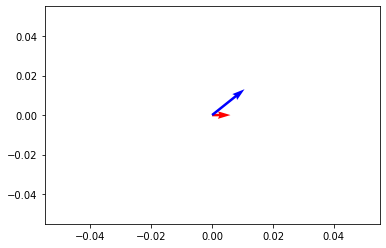

In [0]:
import numpy as np
import matplotlib.pyplot as plt

V = np.array([a, b])
origin = [0], [0] # origin point

plt.quiver(*origin, V[:,0], V[:,1], color=['r','b','g'], scale=21)
plt.show()